In [47]:
# All imports


# General
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

# For CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For handling Images
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

# Tensorflow
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.1.0'

In [1]:
# unzipping files

import zipfile
with zipfile.ZipFile('./Data/face_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
# loading data

df = pd.read_csv("Data/train_data.csv")

### Inspecting and Cleaning Data

In [3]:
df.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


In [4]:
df.shape

(2325, 5)

In [5]:
# renaming column

df = df.rename(columns={'filename': 'filepath'})

In [6]:
# adding path 

df.filepath = 'Data/face_data/'+ df.filepath

In [7]:
df.head()

,filepath,person_id,series,tilt,pan
0,Data/face_data/face_790.jpg,5,1,-15,30
1,Data/face_data/face_2445.jpg,5,1,0,-75
2,Data/face_data/face_2266.jpg,5,2,-15,-60
3,Data/face_data/face_2713.jpg,5,2,0,-90
4,Data/face_data/face_2016.jpg,5,2,15,-75


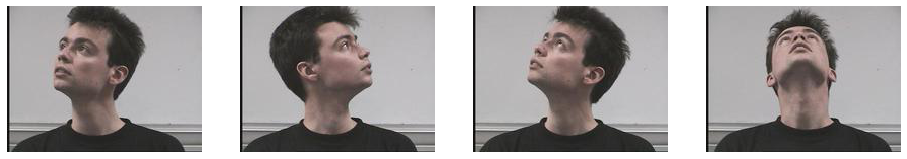

In [8]:
# displaying random images

r_inx = np.random.choice(100, 4)
rand_data = df.loc[r_inx,'filepath']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [9]:
# removing unnessary columns

df.drop(['person_id', 'series'], axis=1, inplace=True)

In [10]:
df

,filepath,tilt,pan
0,Data/face_data/face_790.jpg,-15,30
1,Data/face_data/face_2445.jpg,0,-75
2,Data/face_data/face_2266.jpg,-15,-60
3,Data/face_data/face_2713.jpg,0,-90
4,Data/face_data/face_2016.jpg,15,-75
...,...,...,...
2320,Data/face_data/face_1977.jpg,15,90
2321,Data/face_data/face_701.jpg,-15,90
2322,Data/face_data/face_1343.jpg,15,-30
2323,Data/face_data/face_851.jpg,-60,15


### Generating X and Y Data

In [50]:
# getting XData

# converting all images to arrays to 
x = []
for i in range(len(df)):
    
    im = Image.open(df.iloc[i,0])
    np_im = np.array(im)
    x.append(np_im)
XData = np.array(x) 

In [51]:
# Getting YData

YData = df.iloc[:,1:]

In [52]:
print(XData.shape)
print(YData.shape)

(2325, 144, 192, 3)
(2325, 2)


In [54]:
# splitting test train data

x_train, x_test, y_train, y_test = train_test_split(XData, YData ,test_size=0.20, random_state=42)

In [55]:
# Label Binarizer for Y label

def prepare_targets(y_train, y_test):
    le = LabelBinarizer()
    le.fit(y_train)
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.fit_transform(y_test)
    return y_train_enc, y_test_enc

In [56]:
y_trainLabel1, y_testLabel1 = prepare_targets(y_train.iloc[:,0], y_test.iloc[:,0])
y_trainLabel2, y_testLabel2 = prepare_targets(y_train.iloc[:,1], y_test.iloc[:,1])

In [57]:
# conveting all numpy columns to dataframes

y_trainLabel1 = pd.DataFrame(y_trainLabel1)
y_trainLabel2 = pd.DataFrame(y_trainLabel2)
y_testLabel1 = pd.DataFrame(y_testLabel1)
y_testLabel2 = pd.DataFrame(y_testLabel2)

In [58]:
print(y_trainLabel1.shape)
print(y_trainLabel2.shape)
print(y_testLabel1.shape)
print(y_testLabel2.shape)

(1860, 9)
(1860, 13)
(465, 9)
(465, 13)


In [59]:
# concetinating dataframes and merfing columns

y_train = pd.concat([y_trainLabel1, y_trainLabel2], axis=1)
y_test = pd.concat([y_testLabel1, y_testLabel2], axis=1)

In [62]:
print(y_train.shape)
print(y_test.shape)

(1860, 22)
(465, 22)


In [63]:
y_train.shape

(1860, 22)

In [105]:
input_shape = (192, 144, 3)
from keras.layers import Input


In [106]:

img_input = Input(shape= input_shape, name='input')
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

tiltBranch = Flatten()(x)
tiltBranch = Dense(128, activation='relu')(tiltBranch)
tiltBranch = BatchNormalization()(tiltBranch)
tiltBranch = Dropout(0.5)(tiltBranch)
tiltBranch = Dense(128, activation='relu')(tiltBranch)
tiltBranch = BatchNormalization()(tiltBranch)
tiltBranch = Dropout(0.5)(tiltBranch)
tiltModel = Dense(9, activation='softmax')(tiltBranch)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

panBranch = Flatten()(x)
panBranch = Dense(256, activation='relu')(panBranch)
panBranch = BatchNormalization()(panBranch)
panBranch = Dropout(0.5)(panBranch)
panBranch = Dense(512, activation='relu')(panBranch)
panBranch = BatchNormalization()(panBranch)
panBranch = Dropout(0.5)(panBranch)
panModel = Dense(13, activation='softmax')(panBranch)

model = Model(input=img_input, output=[tiltModel, panModel], name='models')


AttributeError: 'tuple' object has no attribute 'layer'

In [89]:
# Original code

model = Sequential()
model.add(Conv2D(16,(3,3), activation='relu', input_shape= x_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9,activation='softmax', name='tiltModel'))

In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 142, 190, 16)      448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 142, 190, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 71, 95, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 71, 95, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 69, 93, 32)        4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 69, 93, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 34, 46, 32)       

In [81]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
history = model.fit(x_train,y_train, epochs=5, validation_data=(x_test, y_test))

Train on 1860 samples, validate on 465 samples
Epoch 1/5
1860/1860 [==============================] - 31s 17ms/sample - loss: 0.2086 - accuracy: 0.9091 - val_loss: 0.2242 - val_accuracy: 0.9069
Epoch 2/5
1860/1860 [==============================] - 27s 14ms/sample - loss: 0.2031 - accuracy: 0.9129 - val_loss: 0.2947 - val_accuracy: 0.9111
Epoch 3/5
1860/1860 [==============================] - 27s 15ms/sample - loss: 0.1952 - accuracy: 0.9140 - val_loss: 0.1685 - val_accuracy: 0.9240
Epoch 4/5
1860/1860 [==============================] - 27s 15ms/sample - loss: 0.1931 - accuracy: 0.9159 - val_loss: 0.2652 - val_accuracy: 0.8997
Epoch 5/5
1860/1860 [==============================] - 27s 14ms/sample - loss: 0.1874 - accuracy: 0.9165 - val_loss: 0.1629 - val_accuracy: 0.9236


In [73]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(res.history['categorical_accuracy'])
    plt.plot(res.history['val_categorical_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

In [83]:
accuracy = model.evaluate(x_test, y_test, verbose=0)

In [86]:
accuracy

[0.16285248398780822, 0.9235581]